In [1]:
import numpy as np
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers


In [2]:

from autoencoder.model import Sampling

In [3]:
encoder = keras.models.load_model('trained_models/vae_encoder_epoch_24.h5',
                                  custom_objects={'Sampling': Sampling,})

decoder = keras.models.load_model('trained_models/vae_decoder_epoch_24.h5')

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [4]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense (Dense)               (None, 2048)              18432     
                                                                 
 reshape (Reshape)           (None, 8, 8, 32)          0         
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 16)          4624      
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 16)         64        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 16)          0         
                                                           

In [5]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   2432        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 32)   0           ['batch_normalization[0][0]

In [6]:
import h5py
import jax

In [7]:
rng = jax.random.PRNGKey(0)

In [8]:
with h5py.File("/Users/henningse/Downloads/Galaxy10.h5", 'r') as F:
  labels = np.array(F['ans'])
  # reject some we don't care about, keep the rest
  (milkywaylikes_idx,) = np.where(labels > 3)
  images = np.array(F['images'][milkywaylikes_idx])
  # Milky way similar galaxies are class '3' ('-4' normalizes the labels again)
  labels = np.array(F['ans'][milkywaylikes_idx]) - 4

images = images.astype(np.float32) / 255.

# crop the image a bit to get 64x64 shape
def crop_center(images, cropx, cropy):
    _, y, x, _ = images.shape
    startx = x // 2 -(cropx // 2)
    starty = y // 2 -(cropy // 2)    
    return images[:, starty:starty+cropy, startx:startx+cropx, :]

images = crop_center(images=images, cropx=64, cropy=64)

# shuffle once
rng, key = jax.random.split(rng)
shuffle_idx = jax.random.randint(key, (len(images),), 0, len(images))
images = images[shuffle_idx, ...]
labels = labels[shuffle_idx, ...]

In [9]:
ll = encoder.predict(images)

2022-11-30 23:53:22.067161: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


147/147 [==============================] - 2s 9ms/step


In [10]:
ri = decoder.predict(ll[0])

147/147 [==============================] - 3s 16ms/step


In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt


In [12]:
def show_galaxies(images: np.ndarray) -> None:
  n = len(images)
  # always 4 in a column
  ncols = 4
  nrows = -(-n // ncols)
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))

  for img, ax in zip(images, axes.ravel()):
    ax.imshow(img)
    ax.axis('off')
    fig.tight_layout()

# plot first 8 images


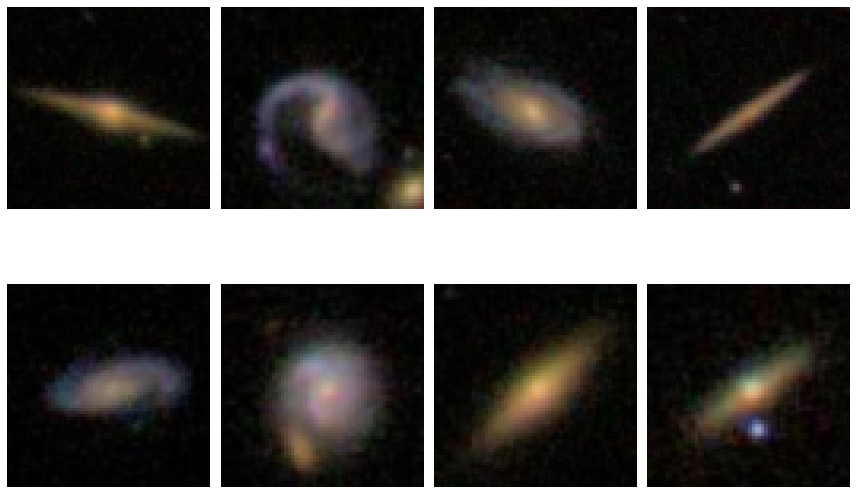

In [13]:
show_galaxies(images[:8])

In [89]:
img_index = np.random.choice(np.arange(len(ri)),size = 8)

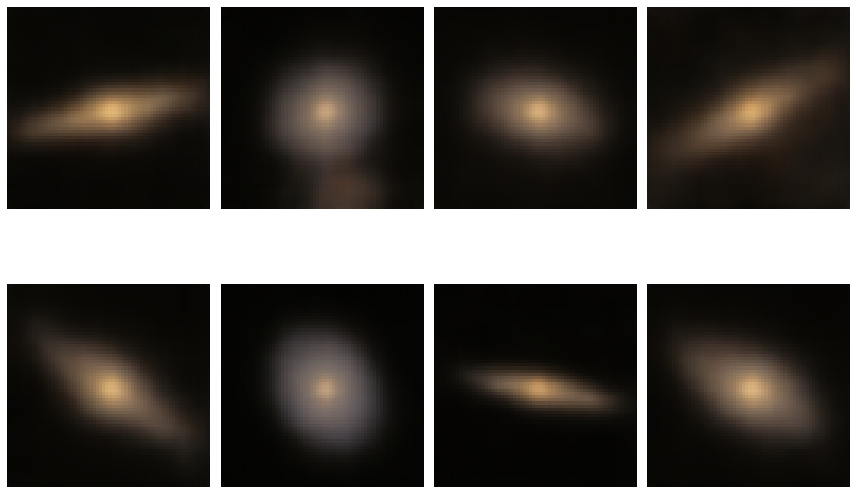

In [90]:
show_galaxies(ri[img_index])

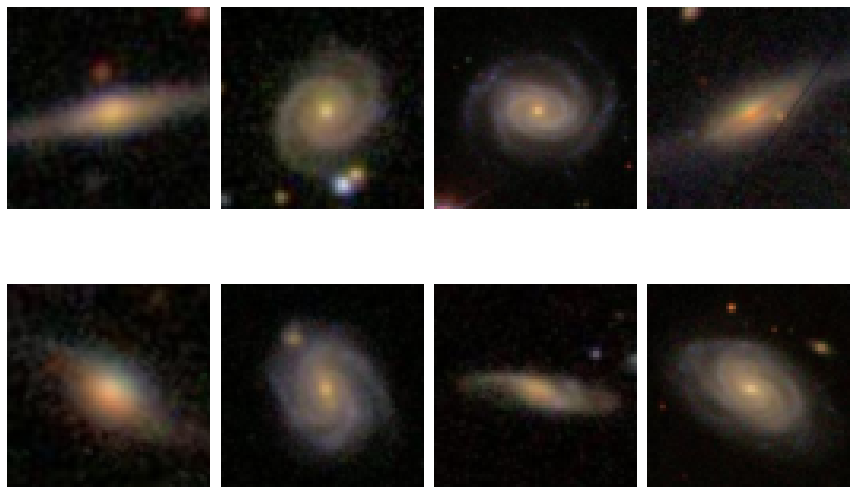

In [91]:
show_galaxies(images[img_index])

In [22]:
latent_features = ll[0]

In [23]:
latent_features.shape

(4686, 8)

In [25]:
import matplotlib.pyplot as plt

In [34]:
labels

array([0, 5, 3, ..., 3, 0, 3], dtype=uint8)

In [41]:
c0 = labels == 0
c2 = labels == 2

In [50]:
np.unique(labels.astype(np.int16))

array([0, 1, 2, 3, 4, 5], dtype=int16)

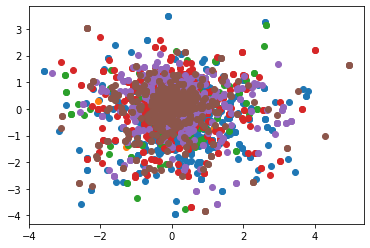

In [63]:

for i in np.unique(labels):
    c = labels == i
    plt.scatter(latent_features[:,6][c], latent_features[:,5][c])

In [66]:
import corner

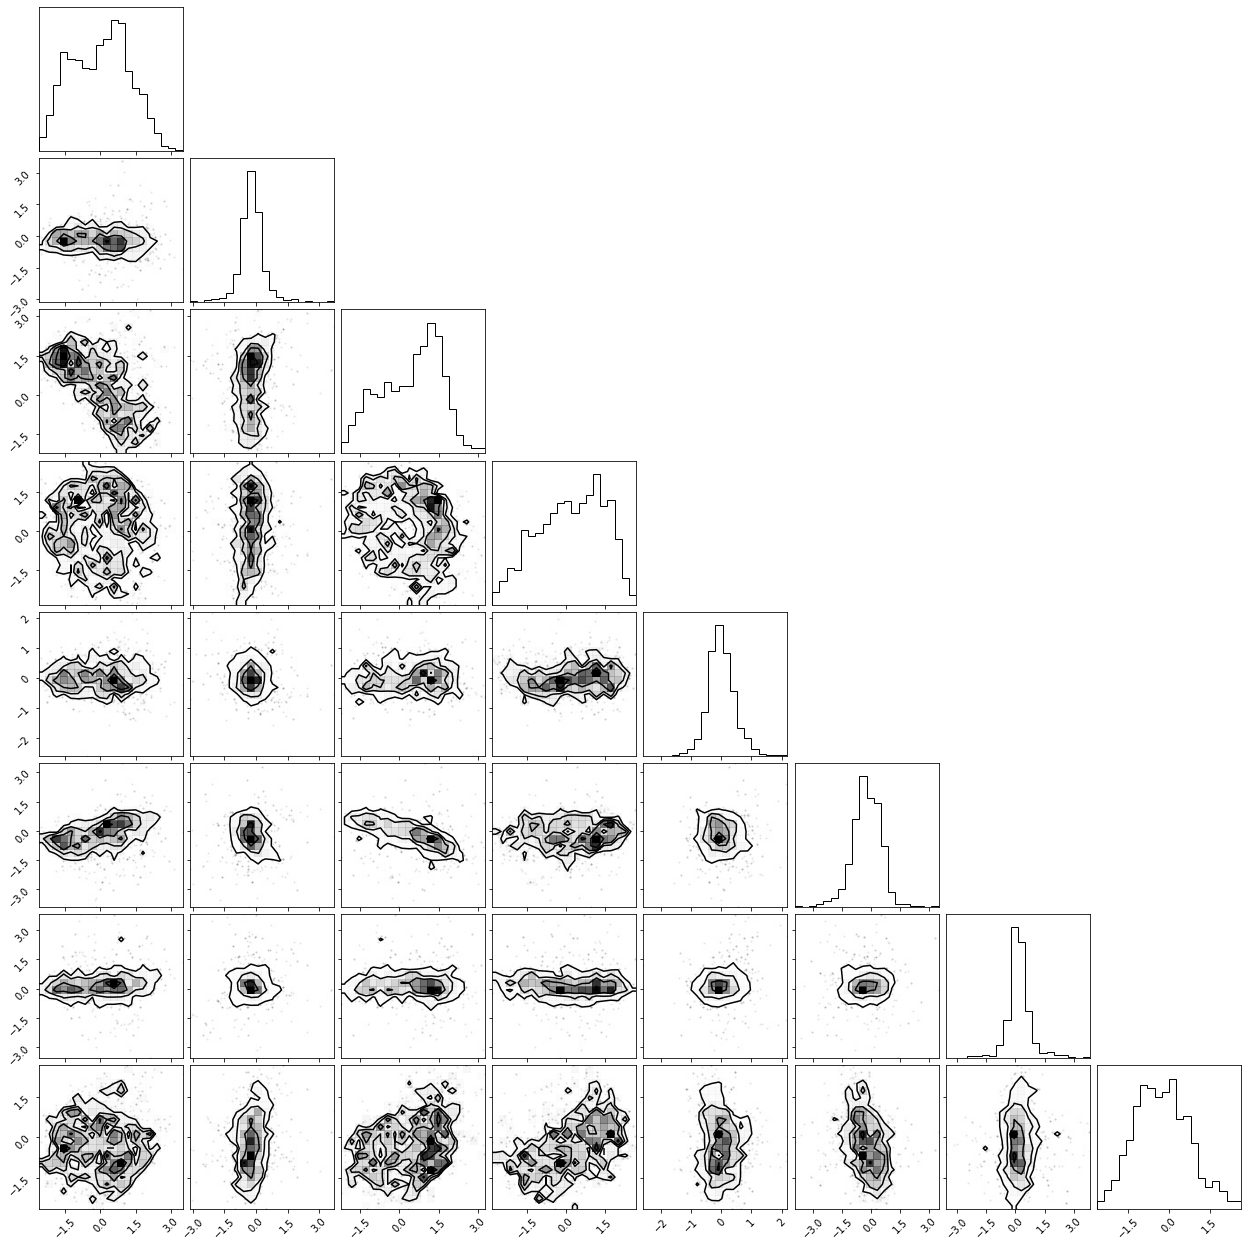

In [95]:

figure = corner.corner(latent_features[labels == 0])

In [99]:
def calculate_distance(features_1, features_2):
    return np.linalg.norm(features_1, features_2)

In [100]:
calculate_distance(latent_features[0], latent_features[1])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [104]:
(latent_features-latent_features[1])**2

array([[4.0359378e+00, 4.5530924e-01, 5.1364279e-01, ..., 1.1626316e+00,
        8.5619621e+00, 7.8934199e-01],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.2320219e+00, 5.7514858e-02, 4.6938303e-01, ..., 6.8423829e+00,
        1.2655972e+01, 3.3789731e-04],
       ...,
       [5.9905243e-01, 5.4209037e-03, 5.5543571e+00, ..., 7.6639605e+00,
        7.8742757e+00, 1.2152939e-02],
       [3.0403817e+00, 7.5770515e-01, 1.7180343e-01, ..., 1.3437766e+00,
        7.7984757e+00, 1.8529156e+00],
       [7.1415335e-02, 7.0424634e-01, 2.7793615e+00, ..., 3.2838488e+00,
        1.0002243e+01, 1.2294508e+00]], dtype=float32)